In [ ]:
import spacy
from spacy import displacy
import pandas as pd
import json
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
mistral = pd.read_csv('/content/mistral_scores_sorted.csv')
user_prompts = mistral['user_prompt'][:30].tolist()

In [ ]:
def get_tags(prompts : list):
  tags = []
  for prompt in prompts:
    doc = nlp(prompt)
    for token in doc:
      tags.append({'token': token.text, 'pos': token.pos_, 'tag' : token.tag_})

  return tags


In [ ]:
tags = get_tags(user_prompts)

In [ ]:
def get_entities(prompts : list):
  entities = []
  for prompt in prompts:
    doc = nlp(prompt)
    for ent in doc.ents:
      entities.append({'entity': ent.text, 'label': ent.label_ })

  return entities

In [ ]:
entities = get_entities(user_prompts)

In [ ]:
with open('/content/results_refined.json', 'r') as j:
    f = json.load(j)

In [ ]:
results = {}
for key in f.keys():
  sum = np.array(f[key])[:,1].astype('float').sum()
  results[key[1:]] = sum


In [ ]:
input_tokens = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

In [ ]:
results_sorted = pd.DataFrame.from_dict(input_tokens, columns = ['Importance'], orient = 'index')

In [ ]:
results_sorted.to_csv("/content/input_tokens_sorted.csv")

In [ ]:
analysis = {}
count = 0
for key in input_tokens.keys():
  for tag in tags:
    if key == tag['token']:
      if analysis.get(key) == None:
        analysis[key] = {'pos' : [tag['pos']], 'tag' : [tag['tag']] , 'importance' : [input_tokens[key]]}
      else:
        analysis[key]['pos'].append(tag['pos'])
        analysis[key]['tag'].append(tag['tag'])
        analysis[key]['importance'].append(input_tokens[key])


In [ ]:
pos_tag = pd.DataFrame.from_dict(analysis, columns = ['pos', 'tag', 'importance'], orient = 'index')

In [ ]:
def get_unique(l : list):
  return list(set(l))

In [ ]:
def fix_decimals(num):
  return "{{:.{}f}}".format(3).format(num[0])

In [ ]:
pos_tag['pos'] = pos_tag['pos'].apply(get_unique)
pos_tag['tag'] = pos_tag['tag'].apply(get_unique)
pos_tag['importance'] = pos_tag['importance'].apply(get_unique)
pos_tag['importance'] = pos_tag['importance'].apply(fix_decimals)

In [ ]:
pos_tag.to_csv("/content/pos_tag_analysis.csv")

In [ ]:
analysis2 = {}
for key in input_tokens.keys():
  for ent in entities:
    if key == ent['entity']:
      if analysis2.get(key) == None:
        analysis2[key] = {'label' : [ent['label']]}
      else:
        analysis2[key]['label'].append(ent['label'])

In [ ]:
ner = pd.DataFrame.from_dict(analysis2, columns = ['label'], orient = 'index')

In [ ]:
l = pos_tag['pos'][:99].tolist()
pos = [x for xs in l for x in xs]
keys = Counter(pos).keys() # equals to list(set(words))
values = Counter(pos).values() # counts the elements' frequency



Text(0, 0.5, 'PoS Tag Count')

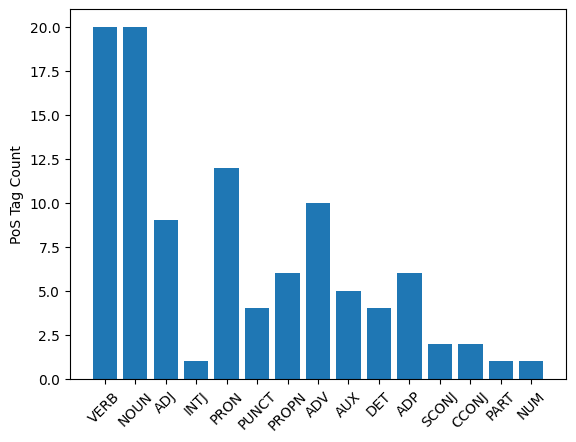

In [ ]:

plt.bar(list(range(0,15)),values, label= keys)
plt.xticks(list(range(0,15)),list(keys) , rotation=45, ha='center')
plt.ylabel('PoS Tag Count')
